In [9]:
import pandas as pd
print(f'Pandas {pd.__version__}')

import numpy as np
print(f'Numpy {np.__version__}')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN,GRU
print(f'Tensorflow {tf.__version__}')

import sklearn
from sklearn.preprocessing import MinMaxScaler
print(f'Sklearn {sklearn.__version__}')

import matplotlib
import matplotlib.pyplot as plt
print(f'Matplotlib {matplotlib.__version__}')

Pandas 1.1.3
Numpy 1.22.2
Tensorflow 2.8.0
Sklearn 1.0.2
Matplotlib 3.3.2


In [10]:
np.random.seed(1234)
tf.random.set_seed(5678)
random_state_seed = 1337

# DATA PREPARATION

In [11]:
df = pd.read_csv(r'\Assignment 3_RNN\GlobalLandTemperaturesByCountry.csv')
#https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalTemperatures.csv
#LandAverageTemperature: global average land temperature in celsius
df = df[df['Country']=='Thailand']
df = df.reset_index(drop=True)
#display(df)

#print(df.isnull().sum())
#display(df[df['AverageTemperature'].isnull()])
#display(df[df['AverageTemperatureUncertainty'].isnull()])

#^uncomment the code above to see NaN data start from index 46 (1820-01-01) to 561 (1862-12-01) and 2370 (2013-09-01)
df = df[562:-1] #so we use data from index 562 to 2369
df = df.reset_index(drop=True)
print(df.isnull().sum())
df

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1863-01-01,22.806,2.022,Thailand
1,1863-02-01,24.700,2.396,Thailand
2,1863-03-01,26.599,0.854,Thailand
3,1863-04-01,27.646,1.523,Thailand
4,1863-05-01,27.756,1.296,Thailand
...,...,...,...,...
1803,2013-04-01,29.885,0.234,Thailand
1804,2013-05-01,29.548,0.286,Thailand
1805,2013-06-01,28.325,0.207,Thailand
1806,2013-07-01,27.564,0.318,Thailand


In [12]:
column_data = df['AverageTemperature']

def convertToMatrix(data, feature_timestep):
    x, y = [], []
    for i in range(len(df)-feature_timestep):
        d = i+feature_timestep
        x.append(data[i:d])
        y.append(data[d])
    return np.array(x), np.array(y)
model_structure = 'GRU'

# 4 TIMESTEPS

In [13]:
feature_timestep = 4
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

4 Features
Data Length for 4 Features: 1804
Length x=y: True
4 Features x shape: (1804, 4)
4 Features y shape: (1804,)


In [14]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
4 Features Trainset Shape: (1443, 4) (1443,)
4 Features Valset Shape: (181, 4) (181,)
4 Features Testset Shape: (180, 4) (180,)


In [15]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1443, 4)
(181, 4)
(180, 4)
x shape after newaxis
(1443, 4, 1)
(181, 4, 1)
(180, 4, 1)
y shape
(1443, 1)
(181, 1)
(180, 1)


In [16]:
#deep GRU model
model = Sequential()

model.add( GRU(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add( GRU(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, None, 128)         50304     
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

C:\Users\Polar\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
145/145 [==============================] - 9s 19ms/step - loss: 0.1936 - mean_absolute_error: 0.1936 - val_loss: 0.1448 - val_mean_absolute_error: 0.1448
Epoch 2/100
145/145 [==============================] - 1s 10ms/step - loss: 0.1424 - mean_absolute_error: 0.1424 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 3/100
145/145 [==============================] - 1s 10ms/step - loss: 0.1221 - mean_absolute_error: 0.1221 - val_loss: 0.0776 - val_mean_absolute_error: 0.0776
Epoch 4/100
145/145 [==============================] - 2s 10ms/step - loss: 0.1145 - mean_absolute_error: 0.1145 - val_loss: 0.0775 - val_mean_absolute_error: 0.0775
Epoch 5/100
145/145 [==============================] - 1s 9ms/step - loss: 0.1108 - mean_absolute_error: 0.1108 - val_loss: 0.0806 - val_mean_absolute_error: 0.0806
Epoch 6/100
145/145 [==============================] - 1s 10ms/step - loss: 0.1066 - mean_absolute_error: 0.1066 - val_loss: 0.0692 - val_mean_absolute_error: 0.0692
Epoch

145/145 [==============================] - 1s 8ms/step - loss: 0.0607 - mean_absolute_error: 0.0607 - val_loss: 0.0535 - val_mean_absolute_error: 0.0535
Epoch 100/100
145/145 [==============================] - 1s 8ms/step - loss: 0.0621 - mean_absolute_error: 0.0621 - val_loss: 0.0586 - val_mean_absolute_error: 0.0586


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_plot_GRU.png",show_shapes=True, show_layer_names = True)

In [17]:
#training detail
history.history

{'loss': [0.1935528665781021,
  0.14244166016578674,
  0.12211795151233673,
  0.11451780050992966,
  0.11081938445568085,
  0.10659672319889069,
  0.10256854444742203,
  0.10353396087884903,
  0.09914815425872803,
  0.0955234244465828,
  0.09668108075857162,
  0.096138596534729,
  0.09153876453638077,
  0.09305666387081146,
  0.08742057532072067,
  0.08945464342832565,
  0.08656857907772064,
  0.08676856756210327,
  0.08395420759916306,
  0.08321547508239746,
  0.08514294028282166,
  0.08145766705274582,
  0.08114463090896606,
  0.07847271114587784,
  0.08002602308988571,
  0.07761653512716293,
  0.07680380344390869,
  0.07754648476839066,
  0.07592315226793289,
  0.07611951977014542,
  0.07381992042064667,
  0.07554048299789429,
  0.0729537084698677,
  0.07339917123317719,
  0.0739036351442337,
  0.07055146992206573,
  0.07293163985013962,
  0.07301496714353561,
  0.07117244601249695,
  0.07001223415136337,
  0.07119009643793106,
  0.07063373178243637,
  0.06873835623264313,
  0.06695

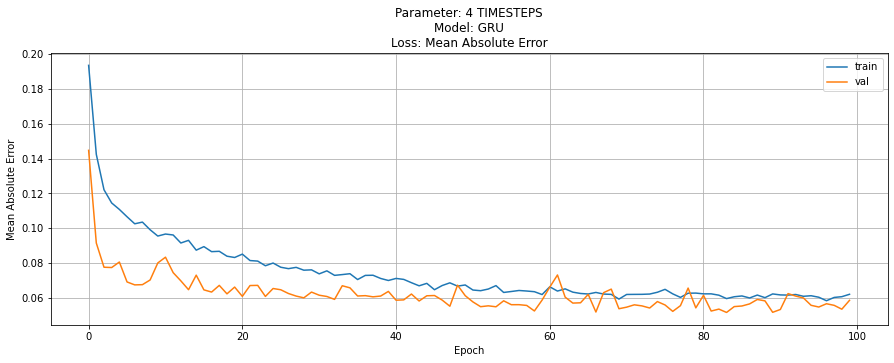

In [18]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [19]:
#laod best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

6/6 [==============================] - 0s 5ms/step - loss: 0.0542 - mean_absolute_error: 0.0542
Model LOSS=0.05421818792819977, METRIC=0.05421818792819977


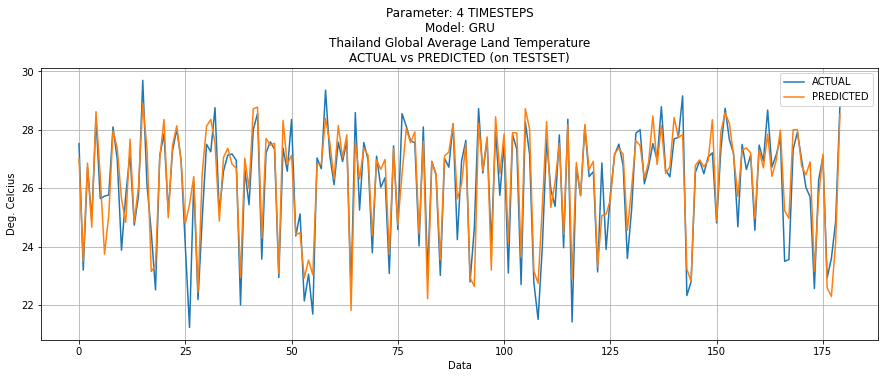

In [20]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [21]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.551453173160553


# 6 TIMESTEPS

In [22]:
feature_timestep = 6
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

6 Features
Data Length for 6 Features: 1802
Length x=y: True
6 Features x shape: (1802, 6)
6 Features y shape: (1802,)


In [23]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
6 Features Trainset Shape: (1441, 6) (1441,)
6 Features Valset Shape: (181, 6) (181,)
6 Features Testset Shape: (180, 6) (180,)


In [24]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1441, 6)
(181, 6)
(180, 6)
x shape after newaxis
(1441, 6, 1)
(181, 6, 1)
(180, 6, 1)
y shape
(1441, 1)
(181, 1)
(180, 1)


In [25]:
#deep GRU model
model = Sequential()

model.add( GRU(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add( GRU(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, None, 128)         50304     
                                                                 
 dropout_9 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_7 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

C:\Users\Polar\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/145 [==============================] - 8s 19ms/step - loss: 0.1973 - mean_absolute_error: 0.1973 - val_loss: 0.1199 - val_mean_absolute_error: 0.1199
Epoch 2/100
145/145 [==============================] - 2s 12ms/step - loss: 0.1404 - mean_absolute_error: 0.1404 - val_loss: 0.1135 - val_mean_absolute_error: 0.1135
Epoch 3/100
145/145 [==============================] - 2s 12ms/step - loss: 0.1246 - mean_absolute_error: 0.1246 - val_loss: 0.0855 - val_mean_absolute_error: 0.0855
Epoch 4/100
145/145 [==============================] - 2s 12ms/step - loss: 0.1196 - mean_absolute_error: 0.1196 - val_loss: 0.0808 - val_mean_absolute_error: 0.0808
Epoch 5/100
145/145 [==============================] - 2s 11ms/step - loss: 0.1120 - mean_absolute_error: 0.1120 - val_loss: 0.0863 - val_mean_absolute_error: 0.0863
Epoch 6/100
145/145 [==============================] - 2s 12ms/step - loss: 0.1065 - mean_absolute_error: 0.1065 - val_loss: 0.0765 - val_mean_absolute_error: 0.0765
Epoch 7/100
145/

145/145 [==============================] - 2s 10ms/step - loss: 0.0589 - mean_absolute_error: 0.0589 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545
Epoch 100/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0597 - mean_absolute_error: 0.0597 - val_loss: 0.0616 - val_mean_absolute_error: 0.0616


In [26]:
#training detail
history.history

{'loss': [0.19731922447681427,
  0.14042159914970398,
  0.12455857545137405,
  0.11959755420684814,
  0.11199084669351578,
  0.10654829442501068,
  0.10482759773731232,
  0.09865178912878036,
  0.09974899142980576,
  0.10075413435697556,
  0.09698936343193054,
  0.0913926213979721,
  0.09173465520143509,
  0.09078089147806168,
  0.09134652465581894,
  0.08813720941543579,
  0.08705200254917145,
  0.08509765565395355,
  0.0809909775853157,
  0.0818304643034935,
  0.07840513437986374,
  0.08014057576656342,
  0.07873114198446274,
  0.07665445655584335,
  0.07746411859989166,
  0.07689385861158371,
  0.0754065290093422,
  0.07548309862613678,
  0.0745692327618599,
  0.07338638603687286,
  0.07415340840816498,
  0.07127904891967773,
  0.07046840339899063,
  0.06902340054512024,
  0.0702991932630539,
  0.07008154690265656,
  0.07003152370452881,
  0.0675569623708725,
  0.06936232000589371,
  0.06651908904314041,
  0.06964187324047089,
  0.0655641034245491,
  0.06699912250041962,
  0.0640362

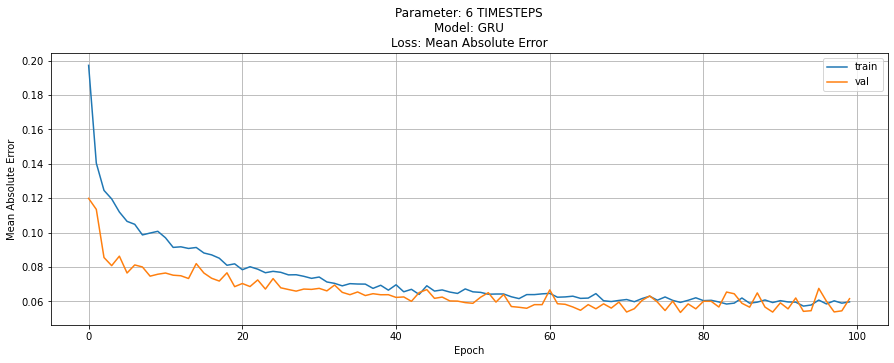

In [27]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [28]:
#laod best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

6/6 [==============================] - 0s 7ms/step - loss: 0.0474 - mean_absolute_error: 0.0474
Model LOSS=0.04739326983690262, METRIC=0.04739326983690262


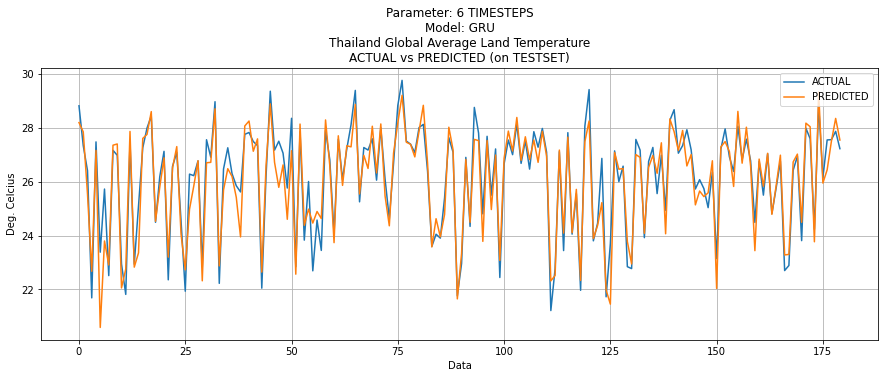

In [29]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [30]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.4820370078086853


# 12 TIMESTEPS

In [31]:
feature_timestep = 12
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

12 Features
Data Length for 12 Features: 1796
Length x=y: True
12 Features x shape: (1796, 12)
12 Features y shape: (1796,)


In [32]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
12 Features Trainset Shape: (1436, 12) (1436,)
12 Features Valset Shape: (181, 12) (181,)
12 Features Testset Shape: (179, 12) (179,)


In [33]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1436, 12)
(181, 12)
(179, 12)
x shape after newaxis
(1436, 12, 1)
(181, 12, 1)
(179, 12, 1)
y shape
(1436, 1)
(181, 1)
(179, 1)


In [34]:
#deep GRU model
model = Sequential()

model.add( GRU(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add( GRU(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, None, 128)         50304     
                                                                 
 dropout_12 (Dropout)        (None, None, 128)         0         
                                                                 
 gru_9 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

C:\Users\Polar\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/144 [==============================] - 9s 25ms/step - loss: 0.1919 - mean_absolute_error: 0.1919 - val_loss: 0.0900 - val_mean_absolute_error: 0.0900
Epoch 2/100
144/144 [==============================] - 3s 19ms/step - loss: 0.1359 - mean_absolute_error: 0.1359 - val_loss: 0.0885 - val_mean_absolute_error: 0.0885
Epoch 3/100
144/144 [==============================] - 3s 19ms/step - loss: 0.1200 - mean_absolute_error: 0.1200 - val_loss: 0.0815 - val_mean_absolute_error: 0.0815
Epoch 4/100
144/144 [==============================] - 3s 19ms/step - loss: 0.1179 - mean_absolute_error: 0.1179 - val_loss: 0.0730 - val_mean_absolute_error: 0.0730
Epoch 5/100
144/144 [==============================] - 3s 19ms/step - loss: 0.1094 - mean_absolute_error: 0.1094 - val_loss: 0.0704 - val_mean_absolute_error: 0.0704
Epoch 6/100
144/144 [==============================] - 3s 19ms/step - loss: 0.1057 - mean_absolute_error: 0.1057 - val_loss: 0.0678 - val_mean_absolute_error: 0.0678
Epoch 7/100
144/

144/144 [==============================] - 3s 17ms/step - loss: 0.0533 - mean_absolute_error: 0.0533 - val_loss: 0.0425 - val_mean_absolute_error: 0.0425
Epoch 100/100
144/144 [==============================] - 2s 17ms/step - loss: 0.0543 - mean_absolute_error: 0.0543 - val_loss: 0.0426 - val_mean_absolute_error: 0.0426


In [35]:
#training detail
history.history

{'loss': [0.19190604984760284,
  0.13585801422595978,
  0.12003124505281448,
  0.11793091893196106,
  0.1093924269080162,
  0.1057448536157608,
  0.10343413800001144,
  0.09882833063602448,
  0.09492980688810349,
  0.0910172089934349,
  0.08842608332633972,
  0.0829281434416771,
  0.08047853410243988,
  0.08170919865369797,
  0.0749027281999588,
  0.0747862383723259,
  0.07335487008094788,
  0.0722624883055687,
  0.07126405090093613,
  0.06944118440151215,
  0.0671427920460701,
  0.06595253199338913,
  0.0651533380150795,
  0.06702291965484619,
  0.06489723175764084,
  0.0634499341249466,
  0.06574109941720963,
  0.06229957938194275,
  0.0607437789440155,
  0.06114332750439644,
  0.05758707970380783,
  0.062025297433137894,
  0.06054536625742912,
  0.05991978198289871,
  0.057476118206977844,
  0.05879921838641167,
  0.06037881597876549,
  0.05829139053821564,
  0.05921699106693268,
  0.058636922389268875,
  0.0569494292140007,
  0.056605320423841476,
  0.05694697052240372,
  0.0581329

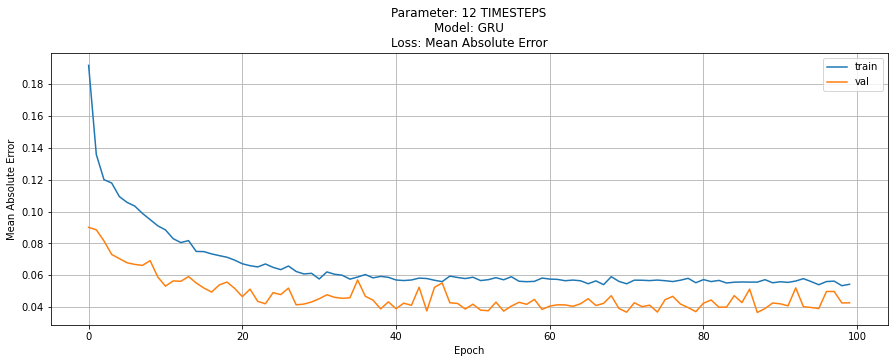

In [36]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [37]:
#laod best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

6/6 [==============================] - 0s 10ms/step - loss: 0.0404 - mean_absolute_error: 0.0404
Model LOSS=0.04041791707277298, METRIC=0.04041791707277298


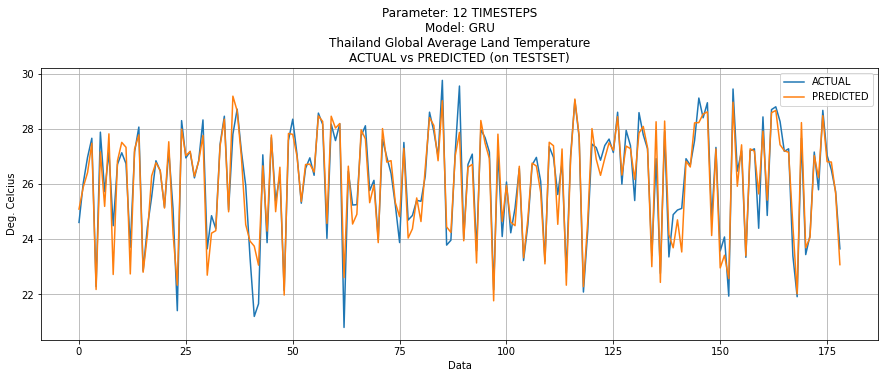

In [38]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [39]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.411090612411499


In [ ]:
#Deep Learning_GRU by 100 epochs 
4: MAE Testset = 0.551453173160553
6: MAE Testset = 0.4820370078086853
12: MAE Testset = 0.411090612411499